In [1]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [2]:
def get_historical_data(symbol, start_date = None):
    api_key = 'NAHQVAQGTX1K8DRZ'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

googl = get_historical_data('AAPL', '2020-01-01')
googl

,open,high,low,close,adj close,volume
2020-01-02,296.240,300.6000,295.19,300.35,73.448805,33911864.0
2020-01-03,297.150,300.5800,296.50,297.43,72.734737,36633878.0
2020-01-06,293.790,299.9600,292.75,299.80,73.314306,29644644.0
2020-01-07,299.840,300.9000,297.48,298.39,72.969499,27877655.0
2020-01-08,297.160,304.4400,297.16,303.19,74.143311,33090946.0
...,...,...,...,...,...,...
2023-04-20,166.090,167.8700,165.56,166.65,166.650000,52456377.0
2023-04-21,165.050,166.4521,164.49,165.02,165.020000,58337341.0
2023-04-24,165.000,165.6000,163.89,165.33,165.330000,41949581.0
2023-04-25,165.190,166.3050,163.73,163.77,163.770000,48714063.0


In [3]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

googl_macd = get_macd(googl['close'], 26, 12, 9)
googl_macd.tail()

,macd,signal,hist
2023-04-20,3.088933,3.107556,-0.018622
2023-04-21,2.897617,3.065568,-0.167951
2023-04-24,2.739433,3.000341,-0.260908
2023-04-25,2.459837,2.892240,-0.432403
2023-04-26,2.211950,2.756182,-0.544232


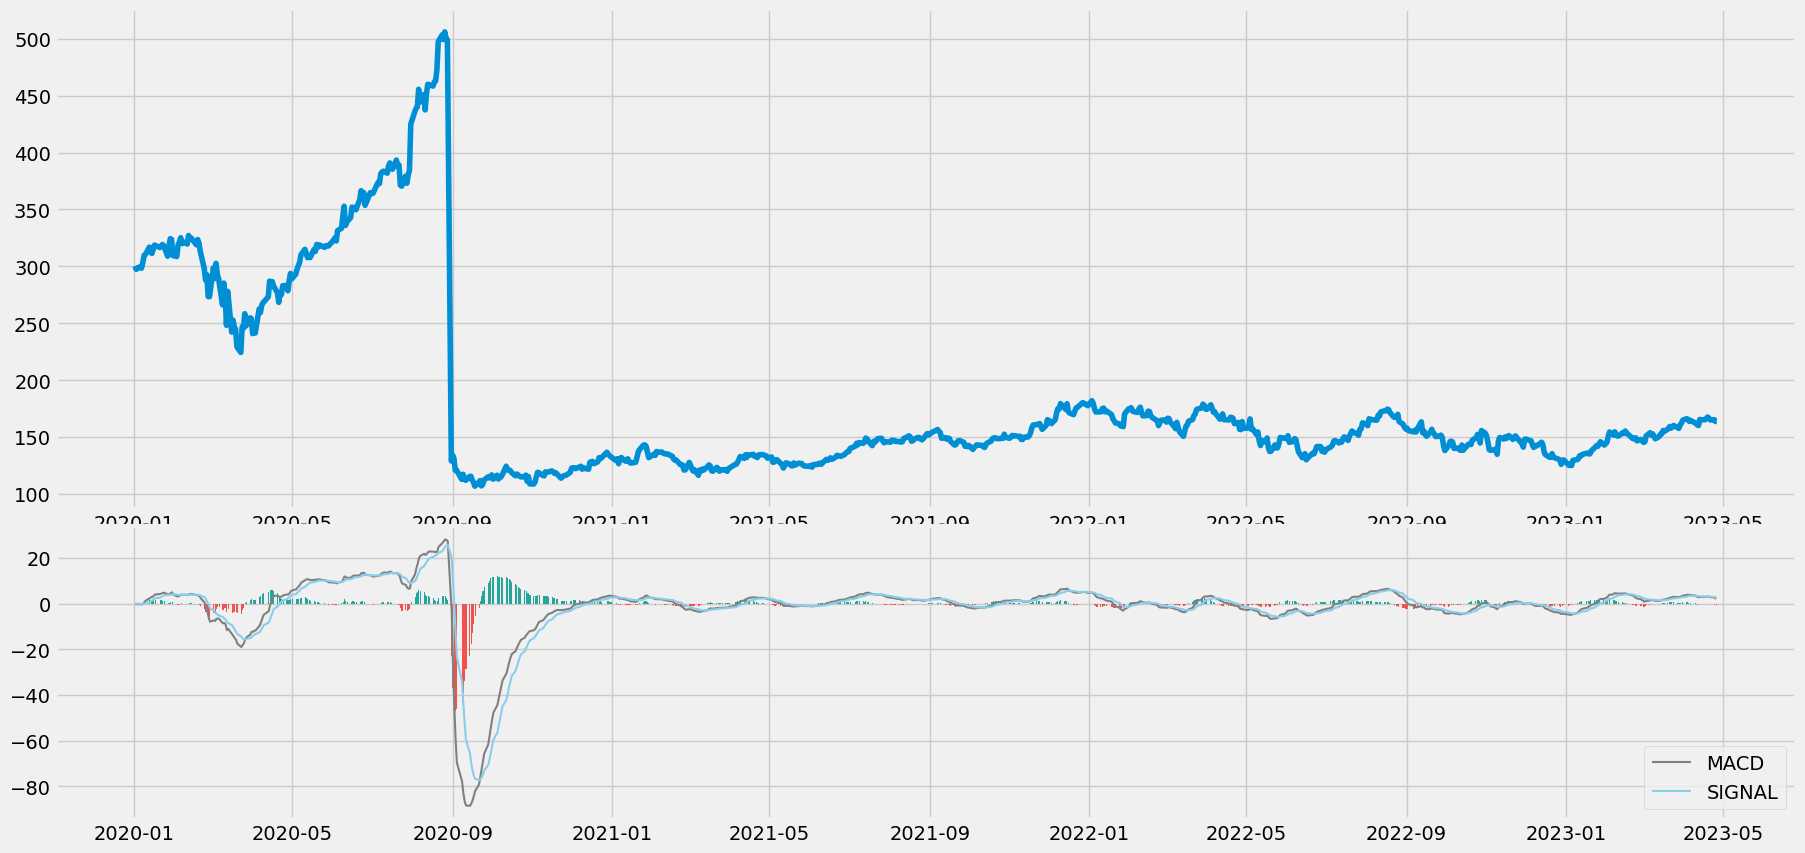

In [4]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(googl['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

NameError: name 'data' is not defined

In [5]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(googl['close'], googl_macd)

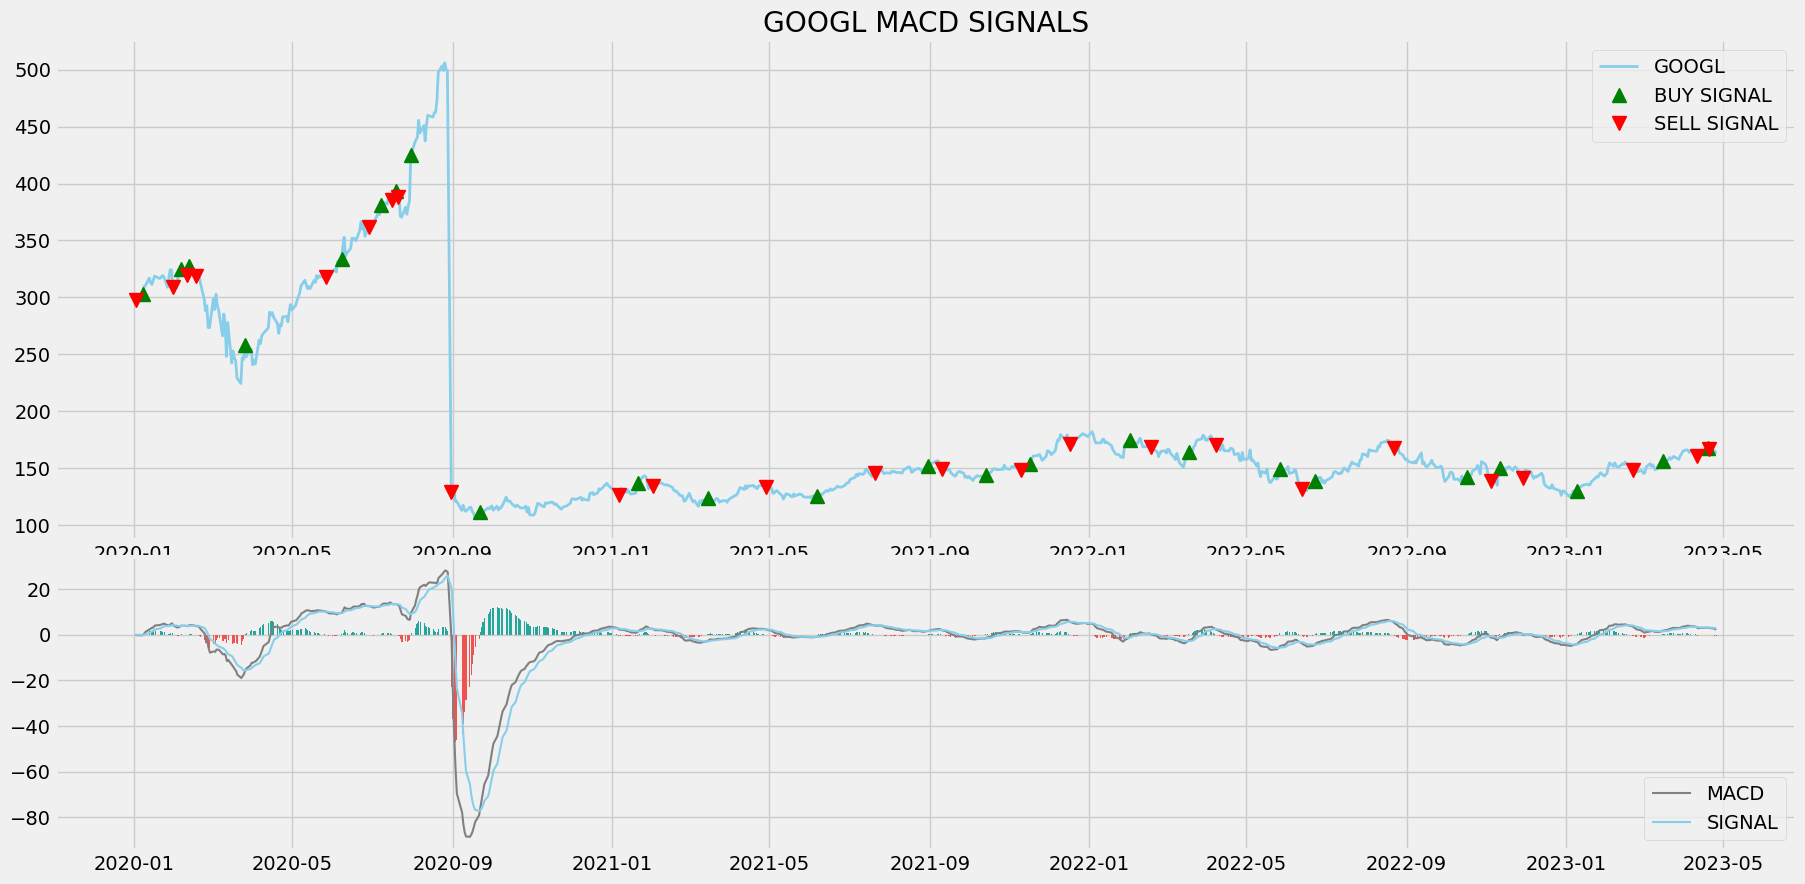

In [6]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(googl['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(googl.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(googl.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
ax2.plot(googl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(googl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(googl_macd)):
    if str(googl_macd['hist'][i])[0] == '-':
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

In [7]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(googl['close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = googl_macd['macd']
signal = googl_macd['signal']
close_price = googl['close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(googl.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(googl.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,macd,signal,macd_signal,macd_position
2020-01-02,300.35,0.000000,0.000000,0,1
2020-01-03,297.43,-0.232934,-0.046587,-1,0
2020-01-06,299.80,-0.223719,-0.082013,0,0
2020-01-07,298.39,-0.326427,-0.130896,0,0
2020-01-08,303.19,-0.020271,-0.108771,1,1
...,...,...,...,...,...
2023-04-20,166.65,3.088933,3.107556,-1,0
2023-04-21,165.02,2.897617,3.065568,0,0
2023-04-24,165.33,2.739433,3.000341,0,0
2023-04-25,163.77,2.459837,2.892240,0,0


In [8]:
googl_ret = pd.DataFrame(np.diff(googl['close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(googl_ret)):
    try:
        returns = googl_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/googl['close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing $100k in GOOGL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing $100k in GOOGL : -45895.68
Profit percentage of the MACD strategy : -46%


In [9]:
def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('MACD Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))


Benchmark profit by investing $100k : 24403.43
Benchmark Profit percentage : 24%
MACD Strategy profit is -70% higher than the Benchmark Profit
